# Unit 4: Central Limit Theorem and Regression Analysis


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Configure plotting
# Set Seaborn style for better visualizations
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [10, 6]

# Set random seed for reproducibility
np.random.seed(42)

## Recap: Law of Large Numbers

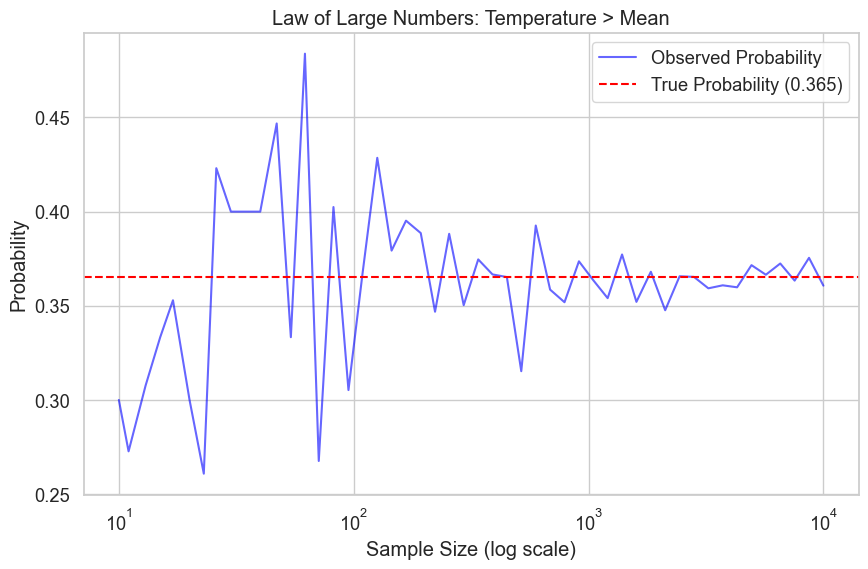

In [5]:
def visualize_law_of_large_numbers(data, threshold_type='mean'):
    """
    Visualize Law of Large Numbers using sensor data
    
    Parameters:
    data : pd.DataFrame - sensor data
    threshold_type : str - 'mean' or 'fixed' for threshold type
    """
    # Set up the threshold
    if threshold_type == 'mean':
        threshold = data['temperature'].mean()
        event_name = 'Temperature > Mean'
    else:
        threshold = 25  # Fixed threshold of 25°C
        event_name = 'Temperature > 25°C'

    # Calculate true probability
    true_prob = np.mean(data['temperature'] > threshold)

    # Simulate increasing sample sizes
    sample_sizes = np.logspace(1, 4, 50).astype(int)  # 10 to 10000; 
    #np.logspace(start, stop, num), num: number of samples to generate; base = 10 by default
    observed_probs = []

    for n in sample_sizes:
        sample = data['temperature'].sample(n=n, replace=True)
        observed_prob = np.mean(sample > threshold)
        observed_probs.append(observed_prob)

    # Create main plot
    plt.figure()

    # Plot: Convergence over sample size
    plt.plot(sample_sizes, observed_probs, 'b-', alpha=0.6, label='Observed Probability')
    plt.axhline(y=true_prob, color='r', linestyle='--', label=f'True Probability ({true_prob:.3f})')
    plt.xscale('log')
    plt.xlabel('Sample Size (log scale)')
    plt.ylabel('Probability')
    plt.title(f'Law of Large Numbers: {event_name}')
    plt.grid(True)
    plt.legend()

"""Load Intel Lab sensor data"""
data = pd.read_csv('processed_sensor_data.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

visualize_law_of_large_numbers(data, threshold_type='mean')


## Part 1: Central Limit Theorem

### What is the Central Limit Theorem?

The Central Limit Theorem (CLT) states that when independent random samples are taken from any distribution:

1. The distribution of sample means approximates a normal distribution
2. This approximation improves with larger sample sizes
3. The mean of the sampling distribution equals the population mean
4. The standard deviation of the sampling distribution equals $\frac{\sigma}{\sqrt{n}}$

### Key Requirements
1. Samples must be independent
2. Sample size should be large enough (typically n ≥ 30)
3. Original population should have finite variance

### Why is CLT Important in Engineering?
- Validates statistical testing methods
- Enables quality control procedures
- Supports measurement system analysis
- Helps in uncertainty quantification
- E.g., Batterly life -  establishing warranty, temperature sensor measurement precision

In [7]:
def simulate_sampling_distribution(population, sample_size, n_samples=1000):
    """Generate sampling distribution of means.
    
    Parameters:
    population (array): Original population data
    sample_size (int): Size of each sample
    n_samples (int): Number of samples to draw
    
    Returns:
    array: Sample means
    """
    sample_means = np.array([np.mean(np.random.choice(population, size=sample_size)) 
                            for _ in range(n_samples)])
    return sample_means

def plot_sampling_distribution(population, sample_size, n_samples=1000):
    """Visualize sampling distribution with theoretical normal curve.
    
    Parameters:
    population (array): Original population data
    sample_size (int): Size of each sample
    n_samples (int): Number of samples to draw
    """
    # Get sample means
    sample_means = simulate_sampling_distribution(population, sample_size, n_samples)
    
    # Create plot
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    # Histogram of sample means
    sns.histplot(data=sample_means, kde=True, ax=ax1)
    ax1.set_title(f'Sampling Distribution (n={sample_size})')
    
    # Add theoretical normal 
    x = np.linspace(min(sample_means), max(sample_means), 100)
    pop_mean = np.mean(population)
    pop_std = np.std(population)
    theoretical_std = pop_std / np.sqrt(sample_size)
    theoretical = stats.norm.pdf(x, pop_mean, theoretical_std)
    ax1.plot(x, theoretical * len(sample_means) * (max(sample_means) - min(sample_means)) / 50,
             'r--', label='Theoretical Normal')
    ax1.legend()
    
    # # Q-Q plot
    # stats.probplot(sample_means, dist="norm", plot=ax2)
    # ax2.set_title('Normal Q-Q Plot')
    
    plt.tight_layout()
    
    # Print statistics
    print('Sampling Distribution Statistics:')
    print(f'Mean of sample means: {np.mean(sample_means):.3f}')
    print(f'Population mean: {pop_mean:.3f}')
    print(f'\nStd of sample means: {np.std(sample_means):.3f}')
    print(f'Expected std (σ/√n): {theoretical_std:.3f}')

## Example 1: Uniform Distribution

Let's demonstrate CLT with uniformly distributed data (like measurement errors with equal probability within a range):

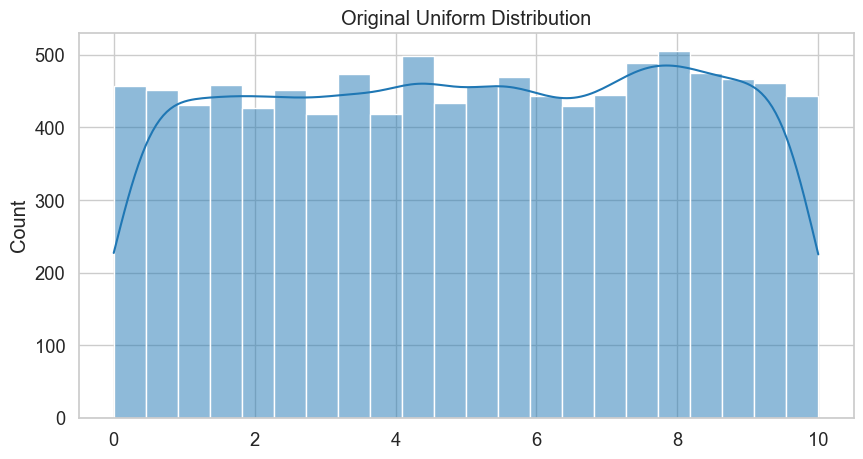

Sampling Distribution Statistics:
Mean of sample means: 5.026
Population mean: 5.050

Std of sample means: 2.036
Expected std (σ/√n): 2.041


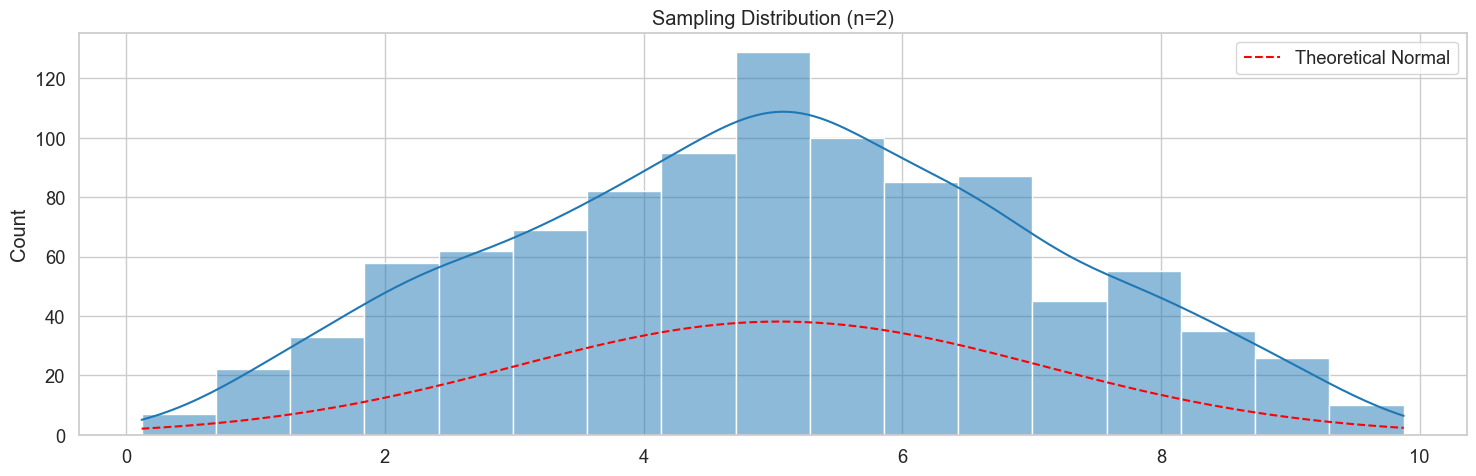

In [9]:
# Generate uniform population data and plot distribution 

uniform_data = np.random.uniform(low=0, high=10, size=10000)

# Plot original distribution
plt.figure(figsize=(10, 5))
sns.histplot(uniform_data, kde=True)
plt.title('Original Uniform Distribution')
plt.show()

# Demonstrate CLT with different sample sizes
n = 2
plot_sampling_distribution(uniform_data, n)
plt.show()

    

Sampling Distribution Statistics:
Mean of sample means: 5.071
Population mean: 5.050

Std of sample means: 2.965
Expected std (σ/√n): 2.887


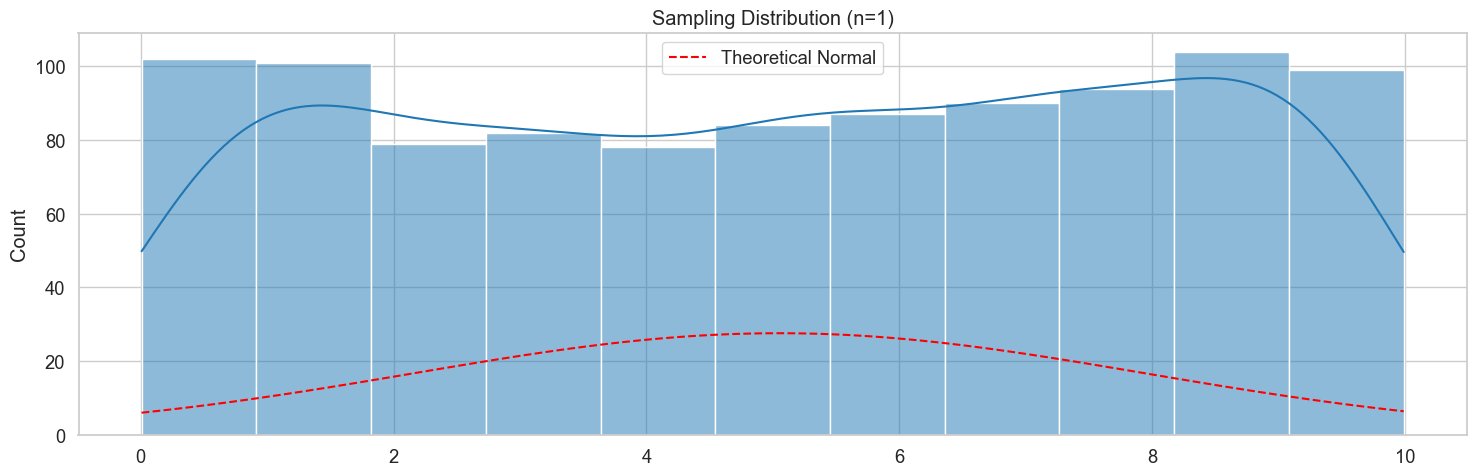

Sampling Distribution Statistics:
Mean of sample means: 5.083
Population mean: 5.050

Std of sample means: 1.268
Expected std (σ/√n): 1.291


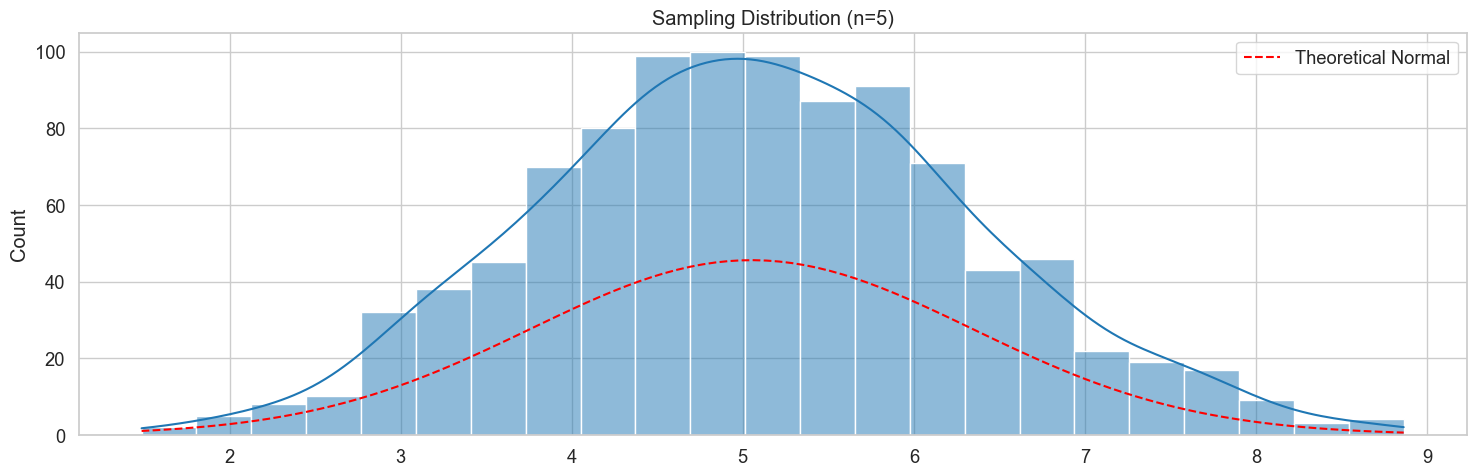

Sampling Distribution Statistics:
Mean of sample means: 5.028
Population mean: 5.050

Std of sample means: 0.542
Expected std (σ/√n): 0.527


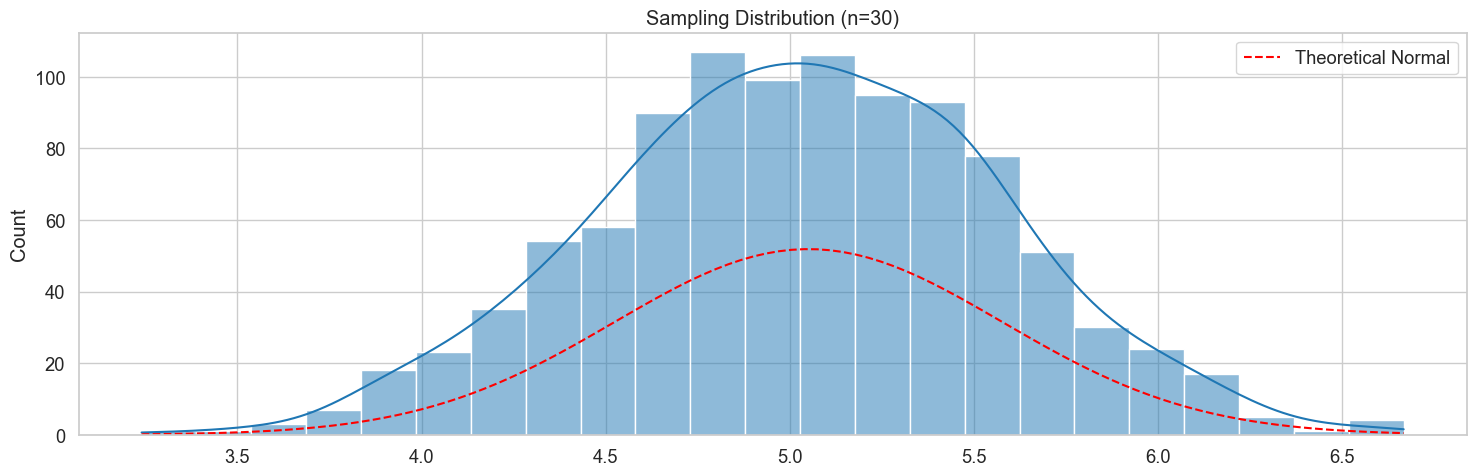

Sampling Distribution Statistics:
Mean of sample means: 5.061
Population mean: 5.050

Std of sample means: 0.294
Expected std (σ/√n): 0.289


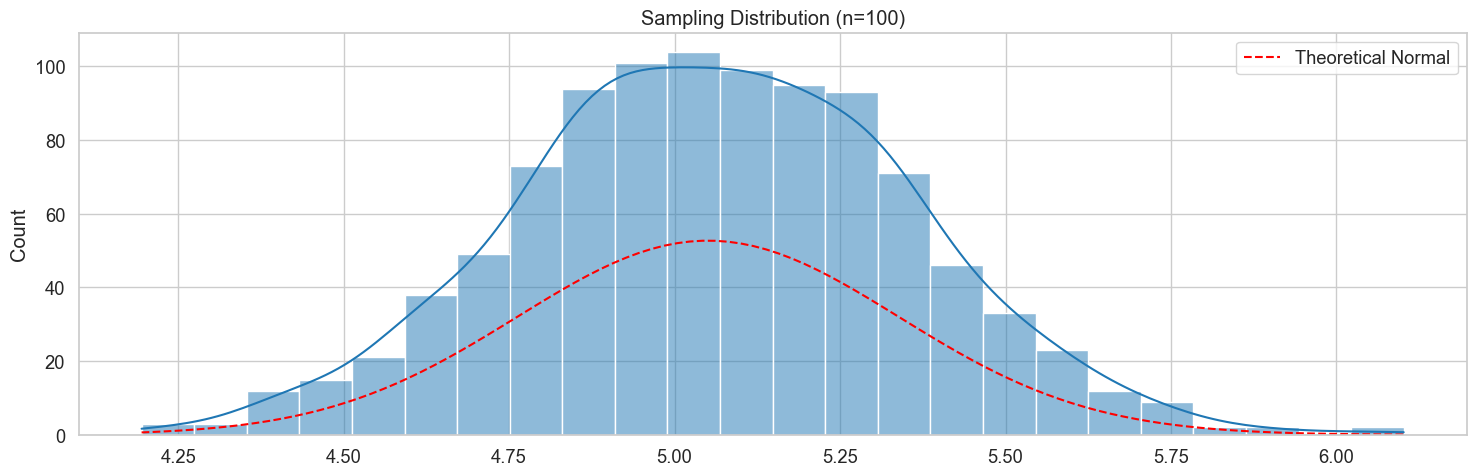

Sampling Distribution Statistics:
Mean of sample means: 5.052
Population mean: 5.050

Std of sample means: 0.090
Expected std (σ/√n): 0.091


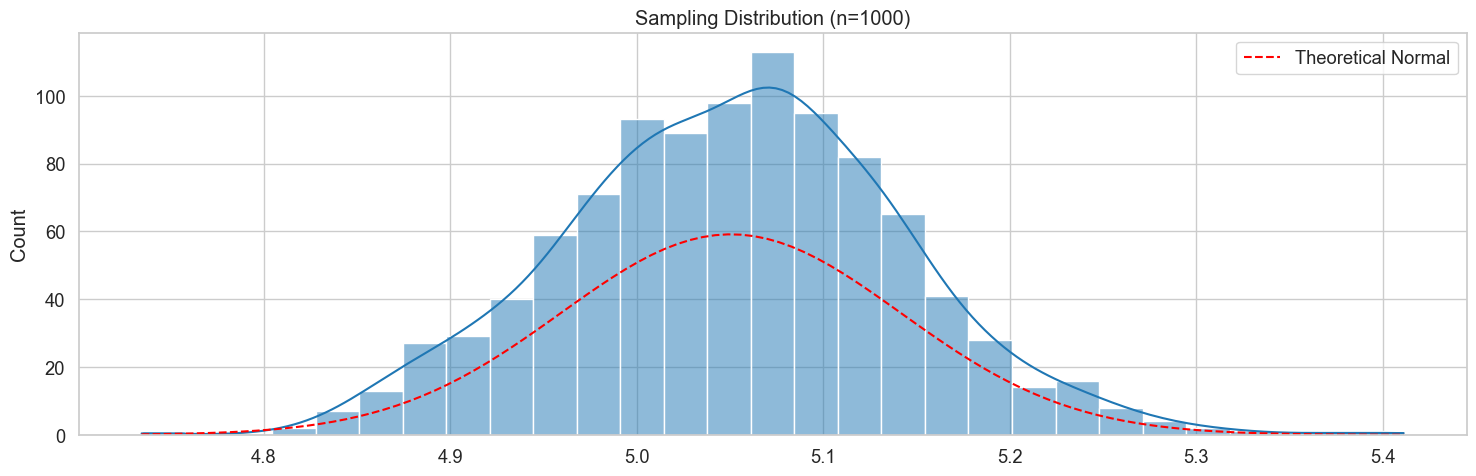

In [10]:
for n in [1, 5, 30, 100, 1000]:
    plot_sampling_distribution(uniform_data, n)
    plt.show()

## Example 2: Exponential Distribution

Now let's look at exponentially distributed data:

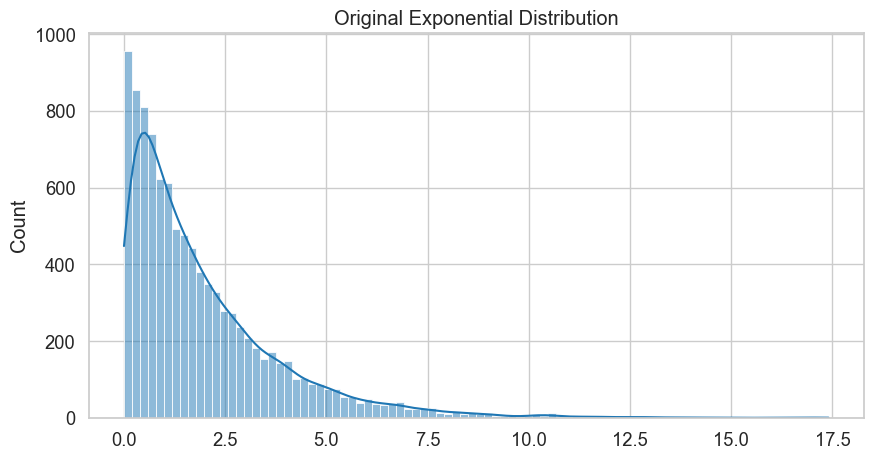

Sampling Distribution Statistics:
Mean of sample means: 1.947
Population mean: 1.935

Std of sample means: 1.913
Expected std (σ/√n): 1.929


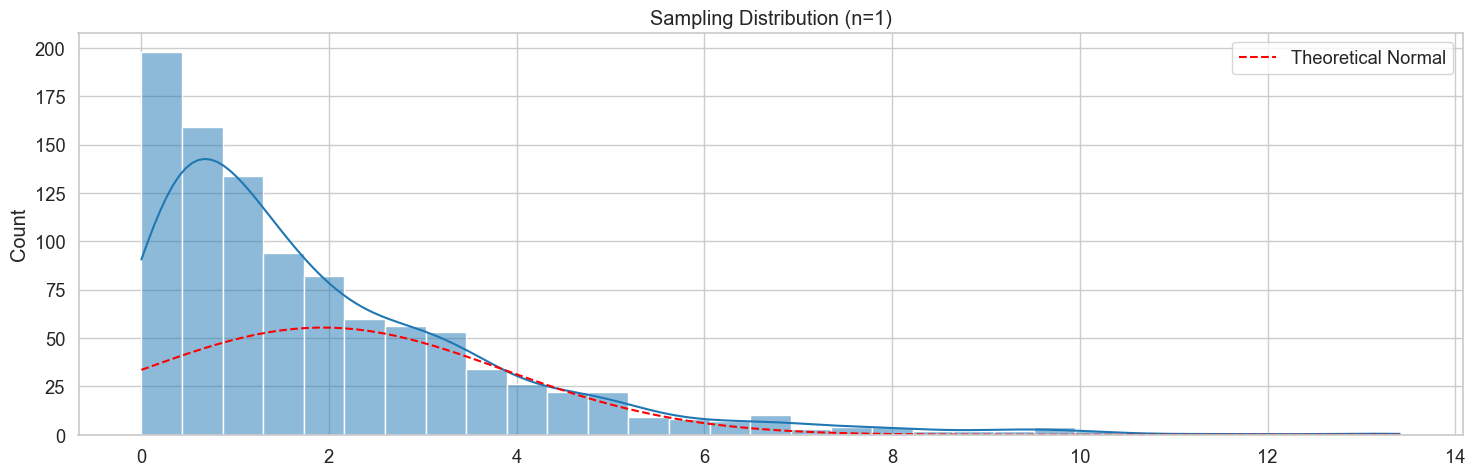

Sampling Distribution Statistics:
Mean of sample means: 1.905
Population mean: 1.935

Std of sample means: 0.814
Expected std (σ/√n): 0.863


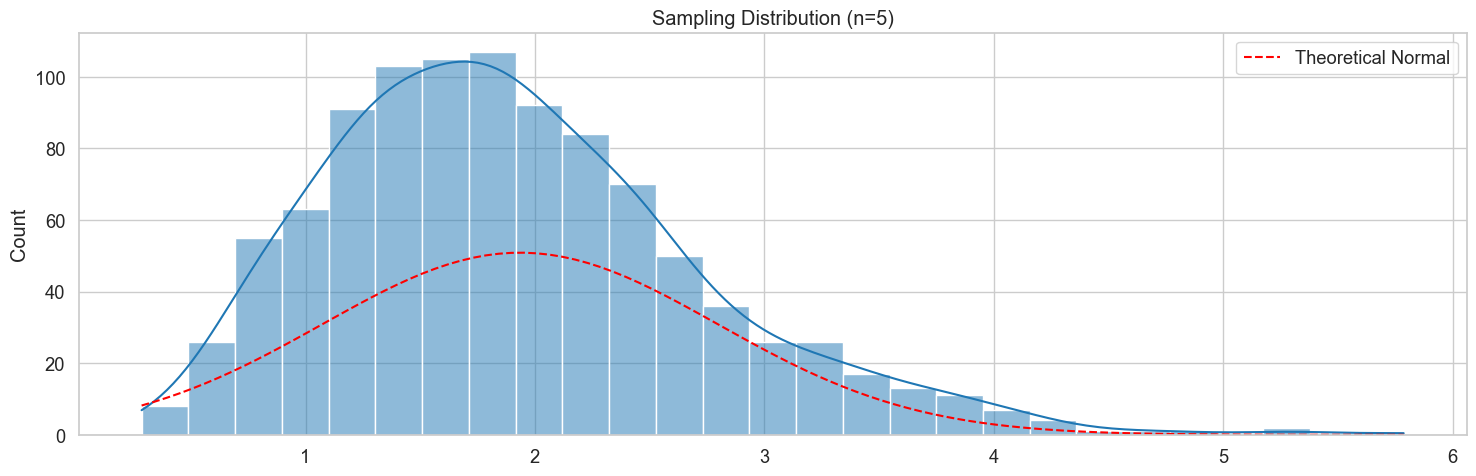

Sampling Distribution Statistics:
Mean of sample means: 1.920
Population mean: 1.935

Std of sample means: 0.353
Expected std (σ/√n): 0.352


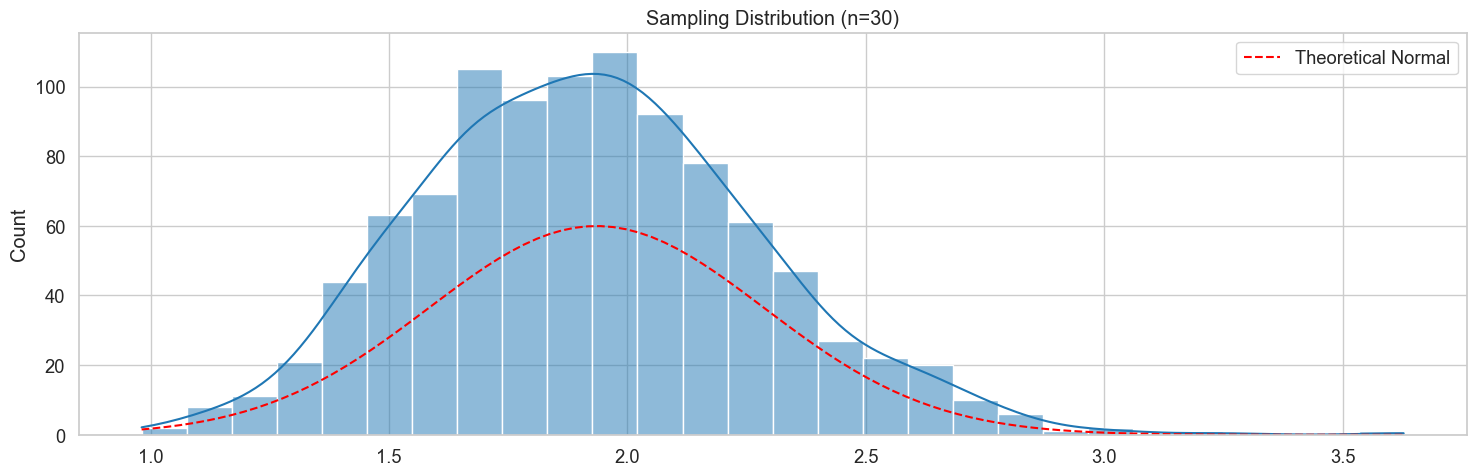

Sampling Distribution Statistics:
Mean of sample means: 1.942
Population mean: 1.935

Std of sample means: 0.194
Expected std (σ/√n): 0.193


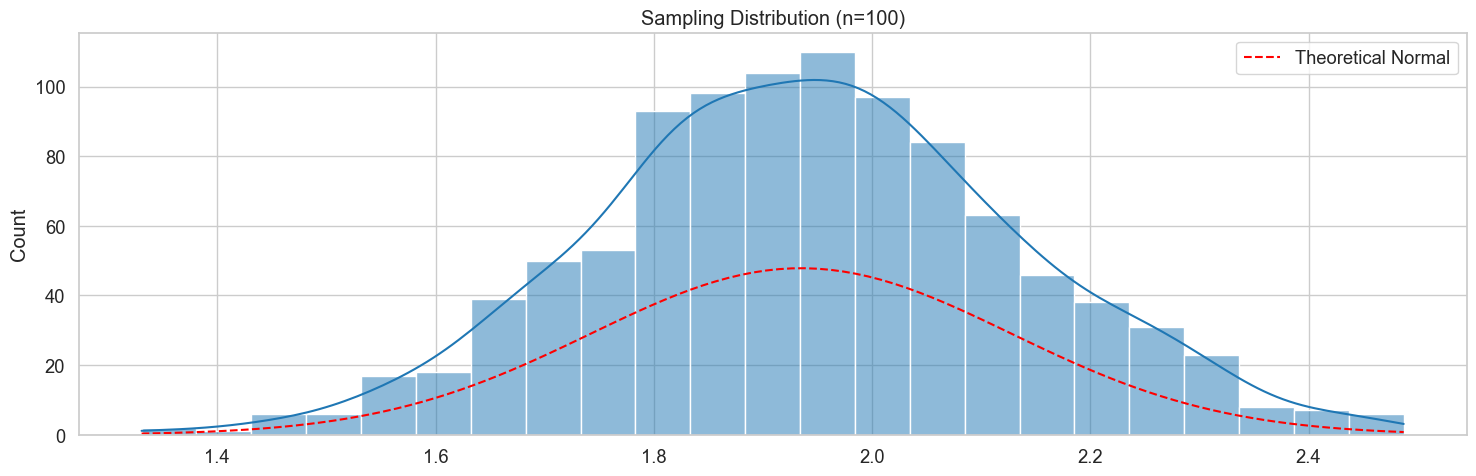

In [12]:
# Generate exponential population data
exponential_data = np.random.exponential(scale=2.0, size=10000)

# Plot original distribution
plt.figure(figsize=(10, 5))
sns.histplot(exponential_data, kde=True)
plt.title('Original Exponential Distribution')
plt.show()

# Demonstrate CLT with different sample sizes
for n in [1, 5, 30, 100]:
    plot_sampling_distribution(exponential_data, n)
    plt.show()

## Practical Implications

### 1. Sample Size Selection
- Larger samples give better normal approximation
- Trade-off between accuracy and cost/time
- n ≥ 30 is often sufficient for most applications
- The exact n required depends on the shape of the underlying population distribution:
  - Symmetric or normal-like distributions need smaller n
  - Skewed or heavy-tailed distributions may need larger n

### 2. Quality Control Applications
- Sampling plans design
- Process capability analysis
- Control chart construction

### 3. Measurement Uncertainty
- Standard error estimation
- Confidence interval construction
- Measurement system analysis

## Exercise: Analyzing Real Engineering Data

Let's apply CLT to analyze temperature sensor measurements:

Individual Measurement Statistics:
Mean: 25.005°C
Std Dev: 0.500°C

Analyzing samples of size 5:
Sampling Distribution Statistics:
Mean of sample means: 24.997
Population mean: 25.005

Std of sample means: 0.218
Expected std (σ/√n): 0.224


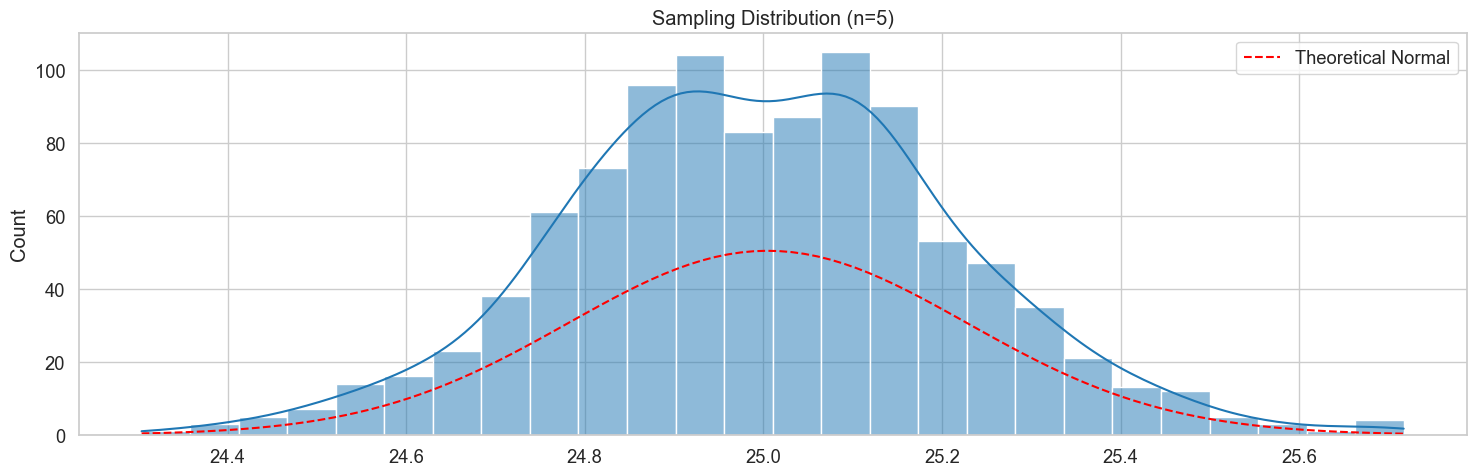


Analyzing samples of size 30:
Sampling Distribution Statistics:
Mean of sample means: 25.002
Population mean: 25.005

Std of sample means: 0.092
Expected std (σ/√n): 0.091


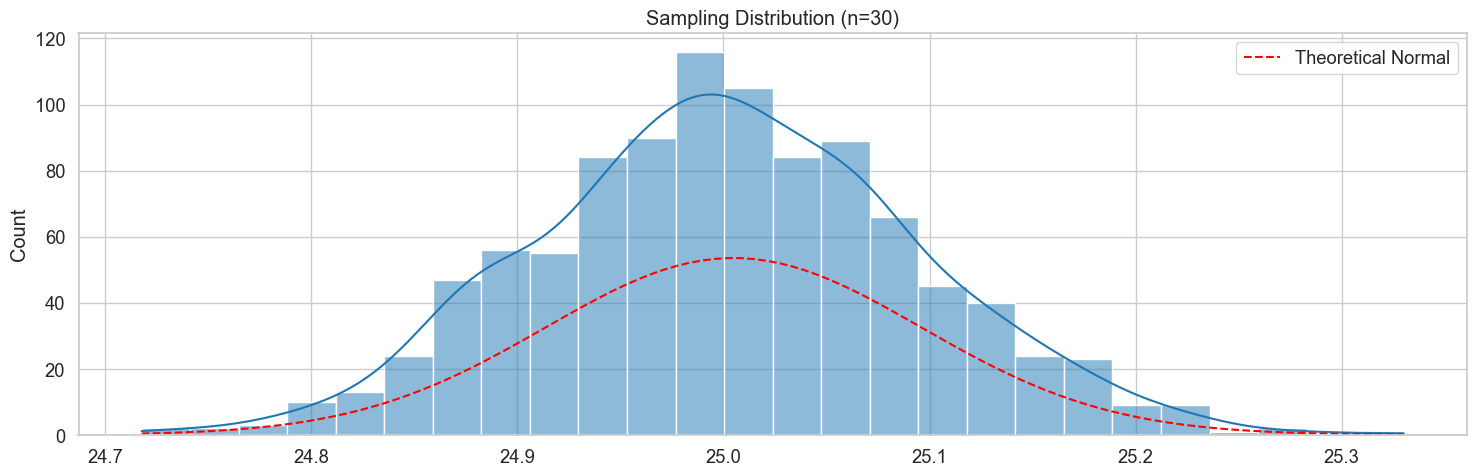


Analyzing samples of size 100:
Sampling Distribution Statistics:
Mean of sample means: 25.004
Population mean: 25.005

Std of sample means: 0.048
Expected std (σ/√n): 0.050


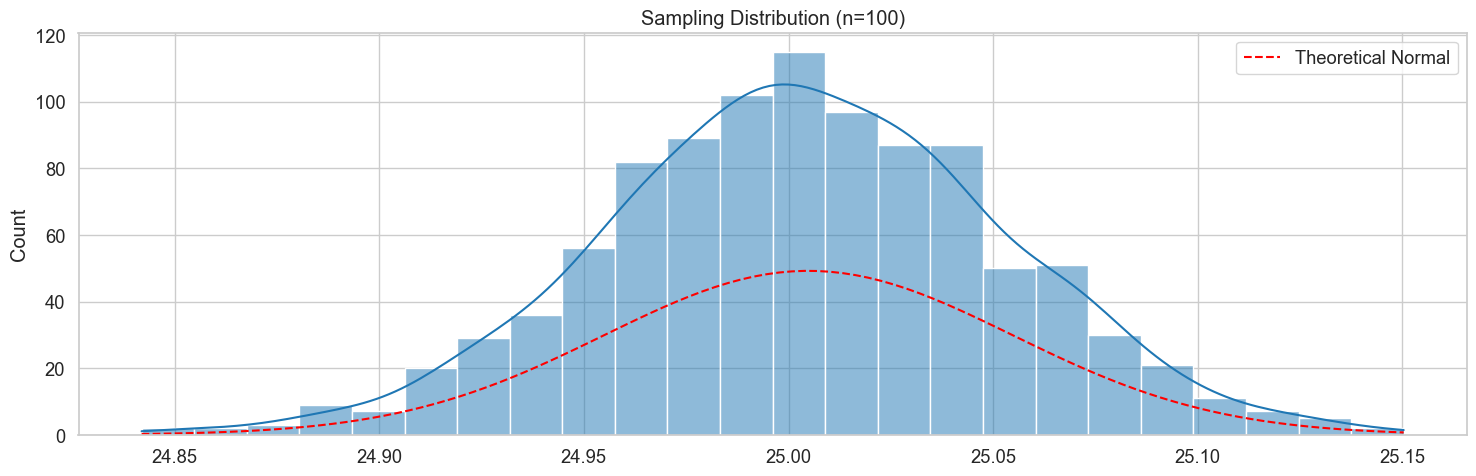

In [14]:
def analyze_sensor_measurements(mean_temp=25.0, std_temp=0.5, n_measurements=1000):
    """Analyze temperature sensor measurements using CLT.
    
    Parameters:
    mean_temp (float): True temperature
    std_temp (float): Sensor noise level
    n_measurements (int): Number of measurements
    """
    # Simulate sensor readings
    measurements = np.random.normal(mean_temp, std_temp, n_measurements)
    
    print('Individual Measurement Statistics:')
    print(f'Mean: {np.mean(measurements):.3f}°C')
    print(f'Std Dev: {np.std(measurements):.3f}°C')
    
    # Demonstrate CLT with different sample sizes
    for n in [5, 30, 100]:
        print(f'\nAnalyzing samples of size {n}:')
        plot_sampling_distribution(measurements, n)
        plt.show()

# Run analysis
analyze_sensor_measurements()

## Key Takeaways

1. **Distribution Shape**
   - Sample means become normally distributed regardless of original distribution
   - Convergence rate depends on original distribution and sample size

2. **Precision vs Sample Size**
   - Standard error (the standard deviation of the sample means) decreases with $\sqrt{n}$
   - Diminishing returns for very large samples

3. **Engineering Applications**
   - Enables statistical process control
   - Supports measurement system design
   - Guides sampling plan development

## Additional Notes

### i.
1. **Properties of Sample Mean Distribution**
- Centers exactly at the population mean (μ)
- Forms a normal (Gaussian) distribution
- Standard deviation = population standard deviation / √n
- Gets "tighter" with larger sample sizes

**Manufacturing Example**
- Population: Resistor values from production line
- True (population) mean: 100 Ω
- Population standard deviation: 2 Ω
- Sample size: n = 30

What happens when we take many sets of 30 samples:
1. The sample means will center at 100 Ω
2. Form a normal distribution
3. Standard deviation will be: 2/√30 ≈ 0.37 Ω
4. About 68% of sample means fall within ±0.37 Ω
5. About 95% fall within ±0.74 Ω

**Why This Matters**
1. We can predict how close sample means will be to true mean
2. Larger samples give "tighter" distribution around true mean
3. Helps calculate required sample sizes for desired precision
4. Works regardless of original population distribution
5. Enables statistical inference and confidence intervals





### ii. Theoretical Curve vs Sample Curve 
### When Theoretical Curve is Higher than Sample Curve
- Indicates data is more spread out than expected
- Possible causes:
  * More variability in measurements than theoretical prediction
  * Presence of outliers
  * Mixed populations or multiple modes
  * Process may be less stable than assumed
- Real example:
  * Temperature measurements in a room
  * If theoretical curve peaks higher, actual measurements might be affected by 
    door openings, HVAC cycles, or uneven heating

### When Theoretical Curve is Lower than Sample Curve
- Indicates data is more concentrated than expected
- Possible causes:
  * Less variability than theoretical prediction
  * Data clustering around certain values
  * Potential measurement resolution limits
  * Possible truncation or rounding of values
- Real example:
  * Digital sensor readings
  * If sample curve peaks higher, might indicate limited resolution of sensor
    or digital quantization effects (Converting continuous values into discrete steps - like rounding to nearest available value)

#### Engineering Implications
- Quality Control:
  * Higher theoretical peak → process might need tighter control
  * Lower theoretical peak → might indicate measurement system limitations
- System Design:
  * Higher peak → might need better environmental controls
  * Lower peak → might need higher resolution sensors
- Testing:
  * Higher peak → might need larger sample sizes
  * Lower peak → might have quantization effects

#### What to Check When You See This
- For Higher Theoretical Peak:
  * Check for outliers
  * Look for multiple modes
  * Verify measurement stability
  * Check for environmental factors

- For Lower Theoretical Peak:
  * Check instrument resolution
  * Look for rounded or truncated values
  * Verify measurement range
  * Check for data clustering

## iii) Estimating Sample Size Using Standard Error

1. **Sample Standard Deviation Approach**
   - Use pilot study or preliminary data to estimate standard deviation
   - Formula: 
     ```
     n = (z * σ / E)²
     ```
   Where:
   - z = z-score (confidence level)
   - σ = sample standard deviation
   - E = margin of error
   - n = required sample size

2. **Confidence Interval Method**
   - Typical confidence levels:
     * 90% confidence: z = 1.645
     * 95% confidence: z = 1.96
     * 99% confidence: z = 2.576

### 2. Practical Engineering Guidelines

1. **Rule of Thumb**
   - Minimum sample size: n ≥ 30
   - Provides reasonable approximation of normal distribution
   - Sufficient for most statistical analyses

2. **Sample Size Considerations**
   - Depends on:
     * Desired precision
     * Variability in data
     * Confidence level
     * Statistical power needed


## iv) On Q-Q plot
Deviations from the straight line indicate deviations from the theoretical distribution:

1. **Upward Curve (Right Skew/Heavy Tail)**
- Shape: ⌣ (curves up at the ends)
- Means: More large values than expected 
- Engineering Examples:
  * Server response times: Occasional very long delays
  * Component failure times: Some components last much longer
  * Power consumption spikes: Rare high-power events
  * Network latency: Occasional large delays

2. **Downward Curve (Left Skew)**
- Shape: ⌢ (curves down at the ends)
- Means: More small values than expected
- Engineering Examples:
  * Battery life near end-of-life: Many early failures
  * Sensor readings near minimum range: Clustering at lower limit
  * CPU usage in overloaded system: Many low readings
  * Signal strength measurements: Limited by noise floor

3. **S-shaped (Light Tails)**
- Shape: S
- Means: Values cluster tighter around mean than expected
- Engineering Examples:
  * Digital sensor with limited resolution
  * Quantized ADC readings
  * Clipped signal measurements
  * Rounded temperature readings

4. **Inverse S-shaped (Heavy Tails)**
- Shape: Reverse S
- Means: More extreme values (both high and low)
- Engineering Examples:
  * Mixed production batches
  * Environmental measurements with day/night cycles
  * Load testing with mixed traffic patterns
  * Vibration measurements with multiple sources


## Part 2: Linear Regression Analysis

### Introduction to Linear Regression

Linear regression is a fundamental statistical method for modeling relationships between variables. In engineering applications, it helps us:
- Predict system behavior
- Understand relationships between variables
- Calibrate sensors
- Analyze system performance

### Basic Concept

Linear regression finds the best-fitting straight line through data points by minimizing the sum of squared differences between predicted and actual values. This line is described by:

y = mx + b  (or kx + d) 

where:
- y is the dependent variable (outcome)
- x is the independent variable (predictor)
- m is the slope (rate of change)
- b is the y-intercept (baseline value)

### Key Components

1. **Data Points**
   - (x, y) pairs of observations
   - x: predictor/feature/input variable
   - y: response/target/output variable

2. **Regression Line**
   - Best-fit line through data points
   - Minimizes sum of squared residuals
   - Represents average relationship between variables

3. **Residuals**
   - Vertical distances between actual y values and predicted values
   - Measure of prediction error
   - Used to assess model fit

### Performance Metrics

1. **R-squared (R²)**
   - Measures proportion of variance explained by model
   - Ranges from 0 to 1
   - Higher values indicate better fit
   - Example interpretation:
     * R² = 0.85 means model explains 85% of variance

2. **Root Mean Square Error (RMSE)**
   - Measures average prediction error
   - In same units as y variable
   - Lower values indicate better fit
   - Useful for comparing models

### Engineering Applications

1. **Sensor Calibration**
   ```python
   # Example: Temperature sensor calibration
   # x: reference temperature
   # y: sensor readings
   slope = model.coef_[0]  # sensitivity
   intercept = model.intercept_  # offset
   ```

2. **Performance Analysis**
   ```python
   # Example: System load vs response time
   # x: system load percentage
   # y: response time in milliseconds
   ```

3. **Failure Prediction**
   ```python
   # Example: Component wear prediction
   # x: operating hours
   # y: performance metric
   ```

### Common Issues and Solutions

1. **Outliers**
   - Can significantly affect model fit
   - Solutions:
     * Remove if clearly erroneous
     * Use robust regression methods
     * Investigate cause

2. **Non-linearity**
   - When relationship isn't straight line
   - Solutions:
     * Transform variables (log, square root)
     * Use polynomial regression
     * Apply non-linear models

3. **Heteroscedasticity**
   - Varying spread in residuals
   - Solutions:
     * Transform variables
     * Use weighted regression
     * Apply robust methods

### Model Validation

1. **Train-Test Split**
   ```python
   from sklearn.model_selection import train_test_split
   X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.2, random_state=42)
   ```

2. **Cross-Validation**
   ```python
   from sklearn.model_selection import cross_val_score
   scores = cross_val_score(model, X, y, cv=5)
   ```

### Warning Signs

1. **Poor Model Fit**
   - Low R² value
   - Large RMSE
   - Pattern in residuals
   - Solution: Check assumptions, try transformations

2. **Overfitting**
   - High R² on training data
   - Poor performance on test data
   - Solution: Collect more data, simplify model

3. **Underfitting**
   - Low R² on both training and test data
   - Large systematic errors
   - Solution: Add features, try non-linear models


In [17]:
def fit_and_plot_regression(X, y, title="Linear Regression Example"):
    """Fit linear regression and visualize results.
    
    Parameters:
    X: Feature array
    y: Target array
    title: Plot title
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # test_size indicates the proportion of the dataset that will be allocated to the test set.
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
    plt.scatter(X_test, y_test, color='green', alpha=0.5, label='Test Data')
    
    # Plot regression line
    plt.plot(X, model.predict(X), color='red', label='Regression Line')
    
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    
    # Print results
    print(f"Model Parameters:")
    print(f"Slope: {model.coef_[0]:.3f}")
    print(f"Intercept: {model.intercept_:.3f}")
    print("\nModel Performance:")
    print(f"R² (Train): {r2_train:.3f}")
    print(f"R² (Test): {r2_test:.3f}")
    print(f"RMSE (Train): {rmse_train:.3f}")
    print(f"RMSE (Test): {rmse_test:.3f}")
    
    plt.grid(True)
    plt.show()

Basic Linear Regression Example:
Model Parameters:
Slope: 1.467
Intercept: 12.472

Model Performance:
R² (Train): 0.956
R² (Test): 0.943
RMSE (Train): 9.191
RMSE (Test): 10.319


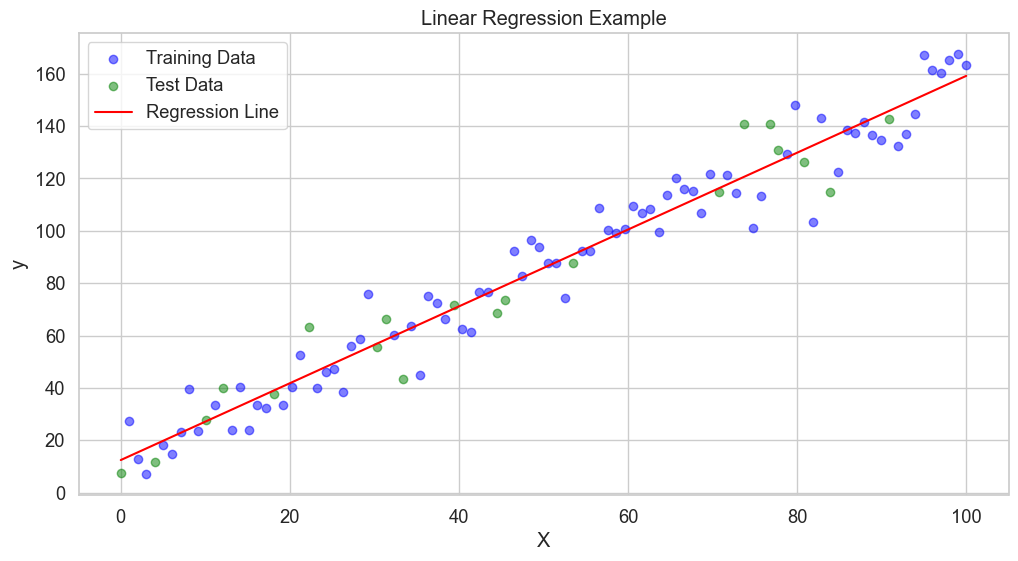

In [18]:
# Example usage with synthetic data

"""Create sample data for regression analysis.

n_samples (int): Number of data points
noise_level (float): Standard deviation of noise

X, y: Feature and target arrays
"""
n_samples=100
noise_level=10

# Generate predictor variable
X = np.linspace(0, 100, n_samples)

# Generate target with noise
true_slope = 1.5
true_intercept = 10
y = true_slope * X + true_intercept + np.random.normal(0, noise_level, n_samples)
    
print("Basic Linear Regression Example:")
fit_and_plot_regression(X.reshape(-1, 1), y)


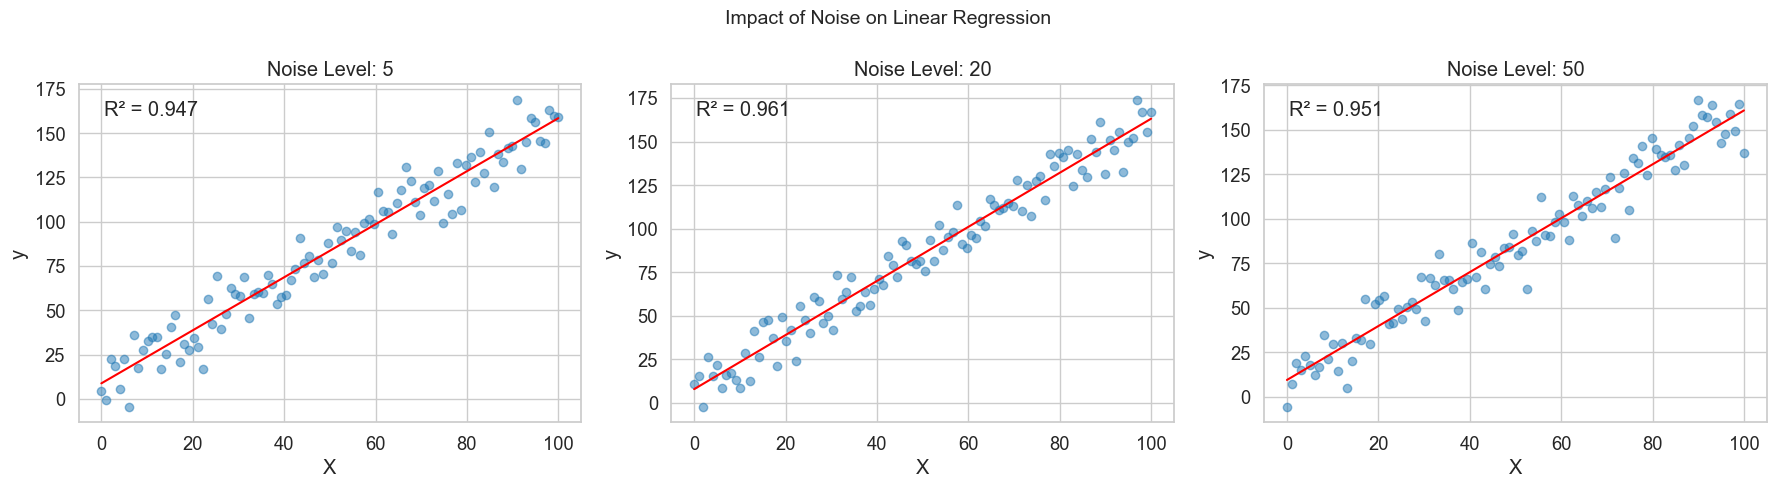

In [19]:
"""Show impact of noise on regression fit."""

noise_levels = [5, 20, 50]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Impact of Noise on Linear Regression', fontsize=14)

n_samples=100
for i, noise in enumerate(noise_levels):
    # Generate data
    y = true_slope * X + true_intercept + np.random.normal(0, noise_level, n_samples)
    
    # Fit model
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    
    # Plot
    axes[i].scatter(X, y, alpha=0.5)
    axes[i].plot(X, model.predict(X.reshape(-1, 1)), color='red')
    axes[i].set_title(f'Noise Level: {noise}')
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    
    # Add R² score
    r2 = r2_score(y, model.predict(X.reshape(-1, 1)))
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', 
                transform=axes[i].transAxes,
                verticalalignment='top')

plt.tight_layout()
plt.show()

The formula for **\( R^2 \)** (coefficient of determination):

$$
R^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}}
$$

Where:
- **$\text{SS}_{\text{res}}$ (Residual Sum of Squares)**:
  $$
  \text{SS}_{\text{res}} = \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2
  $$
  This measures the variance in $y$ that is **not explained** by the regression model (the prediction errors).

- **$\text{SS}_{\text{tot}}$ (Total Sum of Squares)**:
  $$
  \text{SS}_{\text{tot}} = \sum_{i=1}^n \left( y_i - \bar{y} \right)^2
  $$
  This measures the total variance in $y$ (how far each $y_i$ is from the mean $\bar{y}$).

- $y_i$: The actual observed value for the $i$-th data point.

- $\hat{y}_i$: The predicted value from the regression model for the $i$-th data point.

- $\bar{y}$: The mean of the observed values:
   $$
   \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i
   $$


## Polynomial Regression

Polynomial regression extends linear regression by including polynomial terms. Instead of fitting just a line, it can fit curves to capture non-linear relationships.

Basic form:
y = β₀ + β₁x + β₂x² + β₃x³ + ... + βₙxⁿ + ε

where:
- y is the dependent variable
- x is the independent variable
- βᵢ are the coefficients
- n is the polynomial degree
- ε is the error term

Coefficients (βᵢ) are determined using least square method. 

### Key Concepts

1. **Model Complexity**
   - Higher degrees create more complex curves
   - Degree 1: Linear regression
   - Degree 2: Quadratic (parabola)
   - Degree 3: Cubic
   - Higher degrees: More flexible fits

2. **Feature Transformation**
   ```python
   from sklearn.preprocessing import PolynomialFeatures
   
   # Transform features
   poly = PolynomialFeatures(degree=2)
   X_poly = poly.fit_transform(X)
   # X_poly includes: [1, x, x²]
   ```

3. **Overfitting Risk**
   - Higher degrees can overfit
   - Need to balance flexibility and generalization
   - Use cross-validation to select degree

### Engineering Applications

1. **Non-linear Sensor Calibration**
   ```python
   # Example: Non-linear temperature sensor
   def calibrate_nonlinear_sensor(reference_temps, sensor_readings, degree=2):
       poly = PolynomialFeatures(degree=degree)
       X_poly = poly.fit_transform(reference_temps.reshape(-1, 1))
       
       model = LinearRegression()
       model.fit(X_poly, sensor_readings)
       
       return model, poly
   ```

2. **System Response Curves**
   ```python
   # Example: Load vs Response Time
   def model_system_response(load, response_time, degree=3):
       X = load.reshape(-1, 1)
       poly = PolynomialFeatures(degree=degree)
       X_poly = poly.fit_transform(X)
       
       model = LinearRegression()
       model.fit(X_poly, response_time)
       
       return model, poly
   ```

### Implementation Example

Comparing Different Polynomial Degrees:


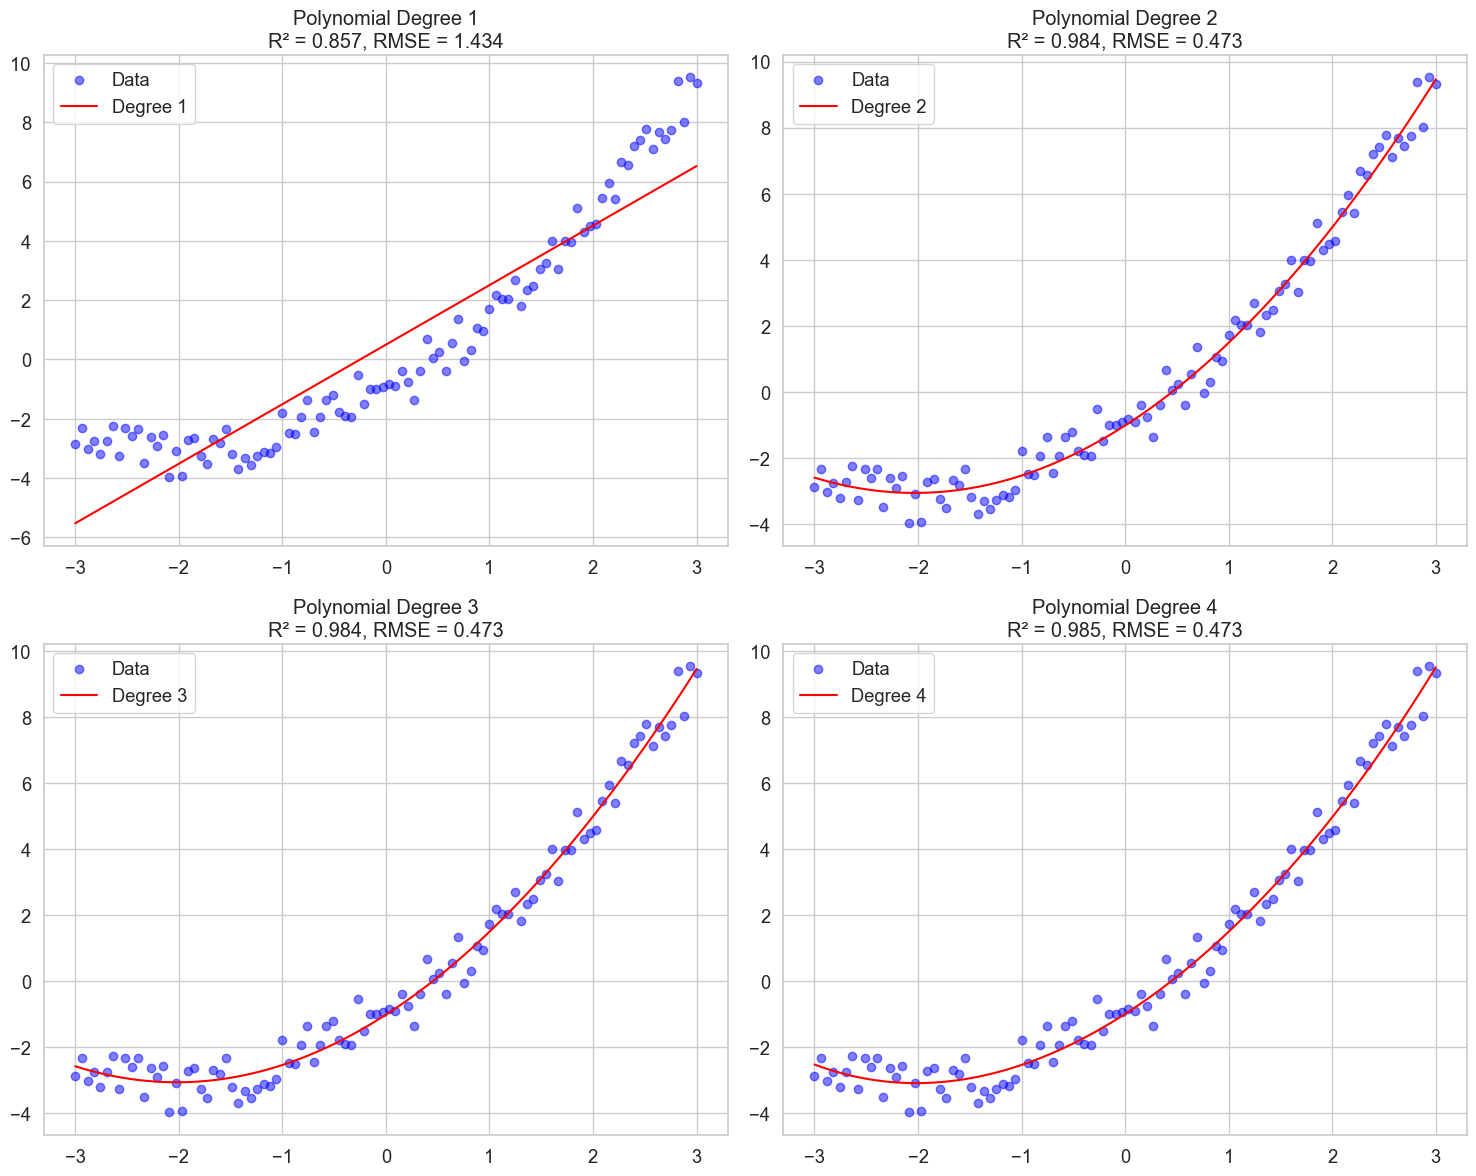


Comparing Cross-validation Scores:


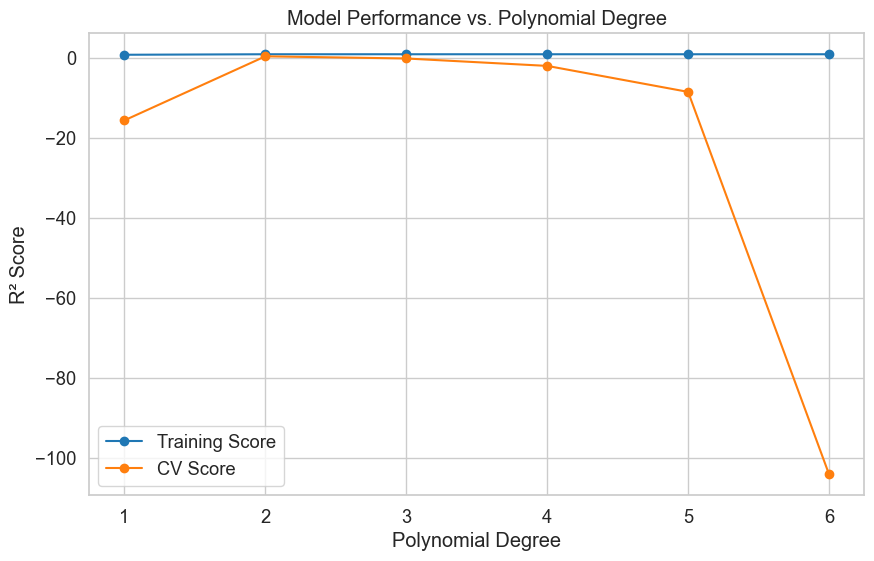


Detailed Analysis of Quadratic Model:
R² Score: 0.984
RMSE: 0.473

Residual Analysis:


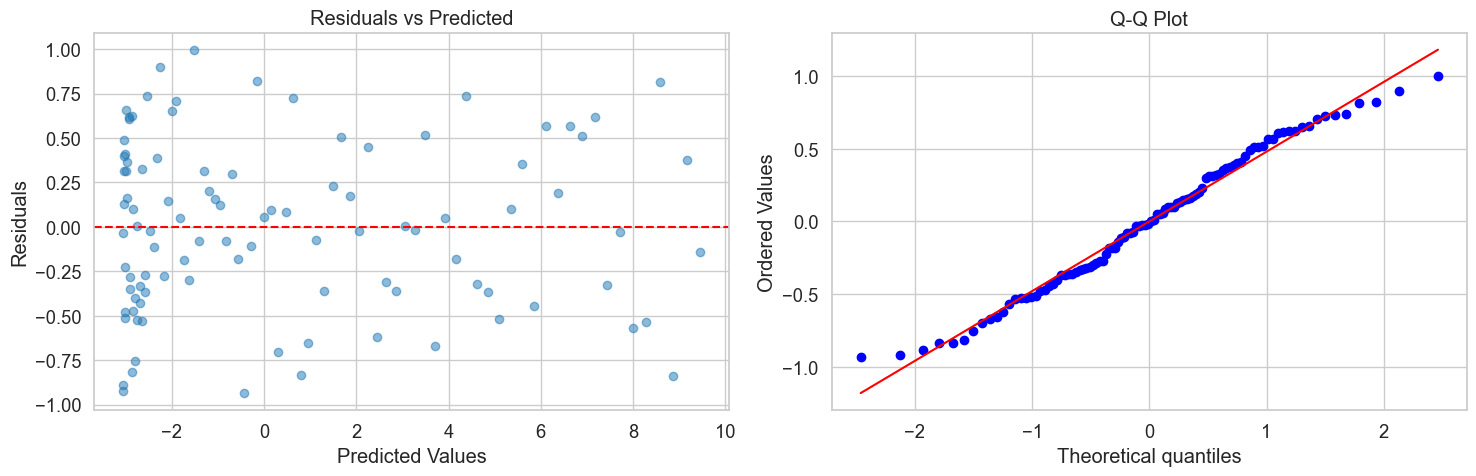

In [22]:
def fit_polynomial_regression(X, y, degree, scaled=True):
    """Fit polynomial regression with optional scaling."""
    # Scale features if requested
    if scaled:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X
        
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    if scaled:
        return model, poly, scaler
    return model, poly, None

def evaluate_model(model, poly, scaler, X, y):
    """Evaluate model performance."""
    if scaler is not None:
        X_transformed = scaler.transform(X)
    else:
        X_transformed = X
        
    X_poly = poly.transform(X_transformed)
    y_pred = model.predict(X_poly)
    
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    return r2, rmse, y_pred

def plot_polynomial_fits(X, y, max_degree=4):
    """Plot polynomial fits of different degrees."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for degree in range(1, max_degree + 1):
        # Fit model
        model, poly, scaler = fit_polynomial_regression(X, y, degree)
        
        # Generate smooth curve for plotting
        X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        X_plot_scaled = scaler.transform(X_plot)
        X_plot_poly = poly.transform(X_plot_scaled)
        y_plot = model.predict(X_plot_poly)
        
        # Calculate metrics
        r2, rmse, y_pred = evaluate_model(model, poly, scaler, X, y)
        
        # Plot
        ax = axes[degree-1]
        ax.scatter(X, y, color='blue', alpha=0.5, label='Data')
        ax.plot(X_plot, y_plot, color='red', label=f'Degree {degree}')
        ax.set_title(f'Polynomial Degree {degree}\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def compare_cv_scores(X, y, max_degree=6):
    """Compare cross-validation scores for different polynomial degrees."""
    train_scores = []
    cv_scores = []
    degrees = range(1, max_degree + 1)
    
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        
        # Fit model and get scores
        model = LinearRegression()
        train_score = model.fit(X_poly, y).score(X_poly, y)
        cv_score = np.mean(cross_val_score(model, X_poly, y, cv=5))
        
        train_scores.append(train_score)
        cv_scores.append(cv_score)
    
    # Plot scores
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_scores, 'o-', label='Training Score')
    plt.plot(degrees, cv_scores, 'o-', label='CV Score')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R² Score')
    plt.title('Model Performance vs. Polynomial Degree')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals(model, poly, scaler, X, y):
    """Plot residuals analysis."""
    # Get predictions
    if scaler is not None:
        X_scaled = scaler.transform(X)
    else:
        X_scaled = X
    X_poly = poly.transform(X_scaled)
    y_pred = model.predict(X_poly)
    residuals = y - y_pred
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Residuals vs Predicted
    ax1.scatter(y_pred, residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs Predicted')
    ax1.grid(True)
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

# Example usage:

# def generate_nonlinear_data(n_points=100):
#     """Generate sample nonlinear data with noise."""
#     X = np.linspace(-3, 3, n_points).reshape(-1, 1)
#     y_true = 0.5 * X**2 + 2 * X - 1  # Quadratic relationship
#     y = y_true + np.random.normal(0, 0.5, size=X.shape)  # Add noise
#     return X, y.ravel()

"""Generate sample nonlinear data with noise."""

n_points=100
X = np.linspace(-3, 3, n_points).reshape(-1, 1)
y_true = 0.5 * X**2 + 2 * X - 1  # Quadratic relationship
y = y_true + np.random.normal(0, 0.5, size=X.shape)  # Add noise
y= y.ravel()
# Generate sample data
# X, y = generate_nonlinear_data(100)

# Plot polynomial fits
print("Comparing Different Polynomial Degrees:")
plot_polynomial_fits(X, y)

# Compare cross-validation scores
print("\nComparing Cross-validation Scores:")
compare_cv_scores(X, y)

# Detailed analysis of best model (degree=2)
print("\nDetailed Analysis of Quadratic Model:")
model, poly, scaler = fit_polynomial_regression(X, y, degree=2)
r2, rmse, _ = evaluate_model(model, poly, scaler, X, y)
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot residuals
print("\nResidual Analysis:")
plot_residuals(model, poly, scaler, X, y)





Analyzing Sensor Data:


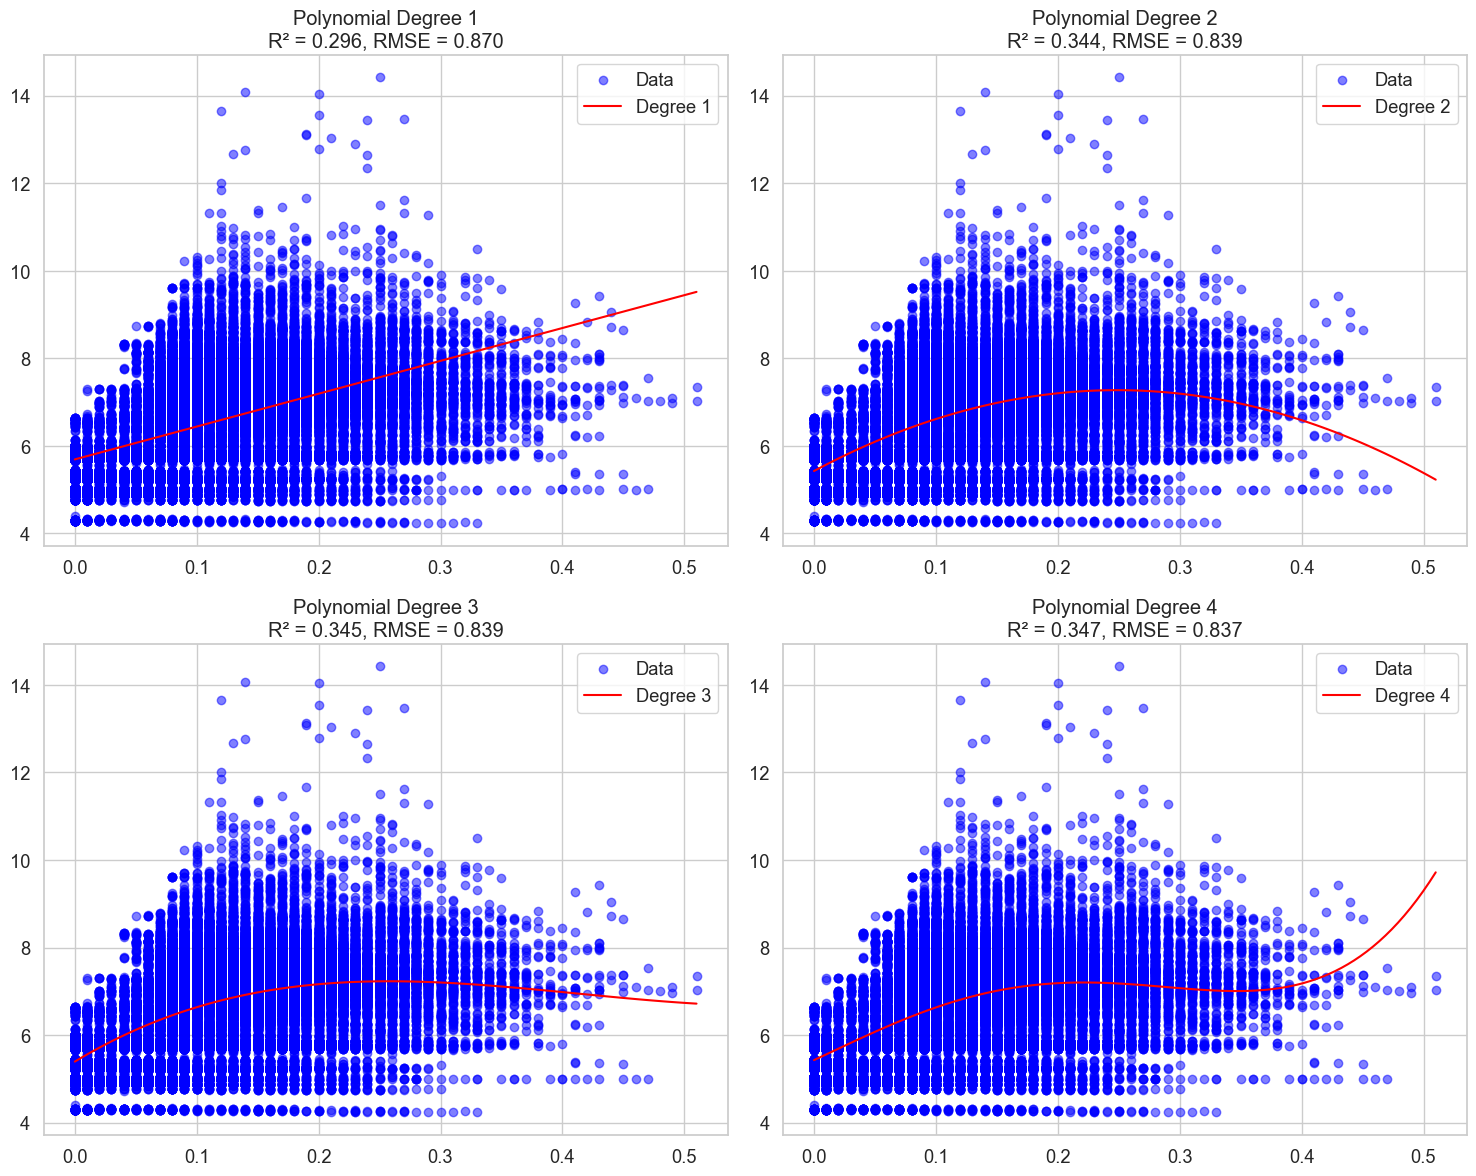

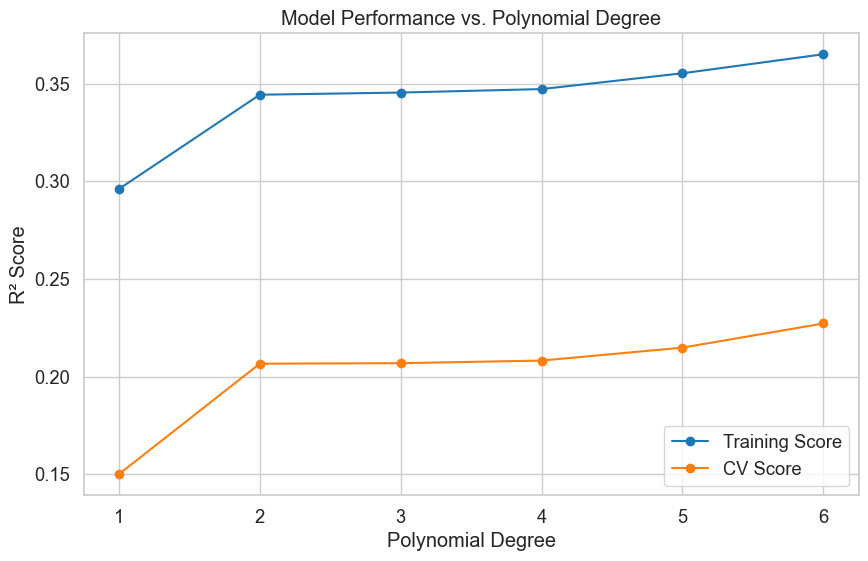

In [23]:
# Example with real data (if available)

df = pd.read_csv('system-1.csv')
df['memory_used_pct'] = (1 - df['sys-mem-available']/df['sys-mem-total']) * 100

X = df['load-15m'].values.reshape(-1, 1)
y = df['memory_used_pct'].values

print("\nAnalyzing Sensor Data:")
plot_polynomial_fits(X, y)
compare_cv_scores(X, y)

## Additional Links to Understand Concepts
On central Limit theorem:\
https://www.youtube.com/watch?v=zeJD6dqJ5lo&t=27s \
https://hackmd.io/2DM4d7wATx-tCNn5QQwm0A#Theoretical-Concepts-of-Machine-Learning \

https://medium.com/swlh/a-simple-refresher-on-confidence-intervals-1e29a8580697